In [1]:
from chem_ocean.ocean_data import dataFetcher, water_column
from chem_ocean.ocean_plt import rawPlotter

In [2]:
from matplotlib.mlab import griddata
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import cm, rcParams

import seaborn as sns
%matplotlib inline

import pandas as pd
import numpy as np

axis_sz= 14
tick_sz= 14

In [12]:
# @todo: must fix the data import to accomodate multiple tracers
    # update: does using cluster_d, but not fully masked 
# @todo: add function for loading data into a dataframe (for seaborn)
    # update: fix cluster_d to have all columns reflect dropna masking will resolve this

The concentration of phosphate in the deep ocean reflects a combination of the amount of phosphate present in the water at the time of water formation, and the amount contributed by regenerated organic matter (phytoplankton that have died, sunk to some depth, and dissolved into constituent molecules).  In 1998, Broecker et al. published a paper suggesting the use of a calculated tracer, PO$_4$* that refleced the concentration of preformed nutrients (the concentration present in the water at the time of water formation).  Their argument was that this would act as a conservative tracer because the non-conservative portion corrected for in the calculation, and could be used to trace the relative contributions of different watermasses at a given location.

The formula they put forth was quite simple:
PO$_4$* = PO$_4$ + O$_2$/175 -1.95

where 175 is the global average moles of oxygen per molecule PO$_4$ needed to respire marine organic matter.  In the 1998 paper, Broecker et al. stipulate that PO$_4$* is only conservative to the extent that the O$_2$/PO$_4$ respiration ratio is constant.

In the subsequent years (as well as those preceding, to a degree) there has been ongoing discussion about this ratio, indeed in Rae and Broecker (2018) which notes that the mixing ratio of North Atlantic sourced water and Southern sourced water in the Pacific derived from PO$_4$* does not match the mixing ratio calculated based on salinity (another conservative tracer).    

While it's difficult to do a complete calculation because of lack of data about the O$_2$:PO$_4$ in the Pacific, does using a Southern Ocean end-member value derived from region specific mass balance calculation in the Atlantic in conjunction with the accepted practice of using the average value in the Pacific close the gap between the NAtl:SO derived from salinity and that derived from PO4*

Calculate PO4* for Atlantic 
Compare to salinity

In theory both PO4* and salinity are conservative tracers so should have bounding endmembers
QQ plot should be a straight line

PO4:NO3 is a straight line more or less because they vary together mostly
PO4:O2 in the deep ocean is not a straight line; O2 is affected by air-sea gas exchange which is temperature sensitive, regeneration of organic matter consumes O2 to release PO4 (the majority of the ocean interior is similar enough in temperature that the amount of O2 consumed doesn't vary because of thermodynamics) which varies depending on the type of organic matter being regenerated and the amount of available oxygen

table of PO4, O2, salinity, PO4*

four color end member for different percentages 
    a.) by salinity
    b.) by PO4*

In [3]:
def ox_po4_convert(dataset):
    ox_convert = lambda x: x*44.661
    dataset.cluster_d['oxygen'] = ox_convert(dataset.cluster_d['oxygen'])

    po4_convert = lambda x,y: x + y/175 - 1.95
    dataset.cluster_d['po4_star'] = po4_convert(dataset.cluster_d['phosphate'], dataset.cluster_d['oxygen'])
    return dataset

In [29]:
tracers = ['phosphate', 'oxygen', 'nitrate', 'salinity']
tracer_string = ','.join(tracers)


In [30]:
dataset_Atl = dataFetcher()
dataset_Atl.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 WHERE longitude < 0 and longitude >-70 and depth >=3000'.format(tracer_string),['latitude', 'longitude', 'depth']+tracers, tracers, 'longitude', 'latitude')
dataset_Atl= ox_po4_convert(dataset_Atl)


In [31]:
dataset_high_lat_Atl = dataFetcher()
dataset_high_lat_Atl.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 WHERE (longitude < 0 and longitude >-70) and (latitude >50 or latitude <-45) and depth >=2500'.format(tracer_string),['latitude', 'longitude', 'depth']+tracers, tracers, 'longitude', 'latitude')
dataset_high_lat_Atl= ox_po4_convert(dataset_high_lat_Atl)


In [32]:
print('Atlantic basin below 3000 m (dark), global ocean below 3000 m (light)')
tracers = {'phosphate': ['Phosphate ($\mu$mol/l)', [0, 4], 'g'], 
          'po4_star': ['Phosphate* ($\mu$mol/l)', [0, 2.5], 'b'],
          'oxygen': ['Oxygen ($\mu$mol/l)', [180, 350], 'c'],
          'salinity': ['Salinity (psu)', [34.5, 35.3], 'r'],}

_x_var = 'longitude'
_y_var = 'latitude'

Atlantic basin below 3000 m (dark), global ocean below 3000 m (light)


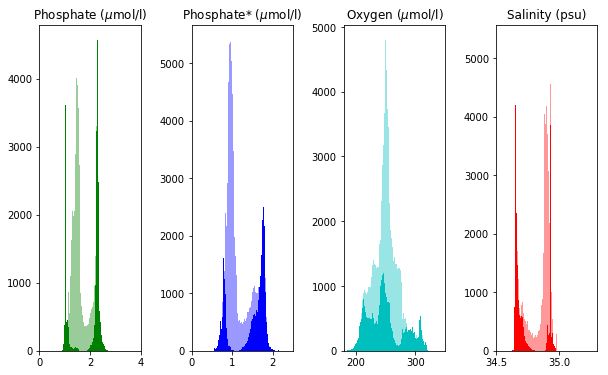

In [33]:
fig = plt.figure(figsize = (10,6))
gs = gridspec.GridSpec(1,len(tracers), width_ratios=np.ones(len(tracers)), wspace=0.5, hspace = 0.4) 
ax_out = []

for ik, tracer in enumerate(tracers):
    ax_out.append(fig.add_subplot(gs[ik]))
    n, bins, patches = ax_out[ik].hist(dataset_Atl.cluster_d[tracer], 100, color = tracers[tracer][2], alpha = .4)
    n, bins, patches = ax_out[ik].hist(dataset_high_lat_Atl.cluster_d[tracer], 100, color = tracers[tracer][2], alpha = 1)
    ax_out[ik].set_xlim(tracers[tracer][1])
    ax_out[ik].set_title(tracers[tracer][0])

['plan', 'plan']
0.07630372047424316
0.12891101837158203


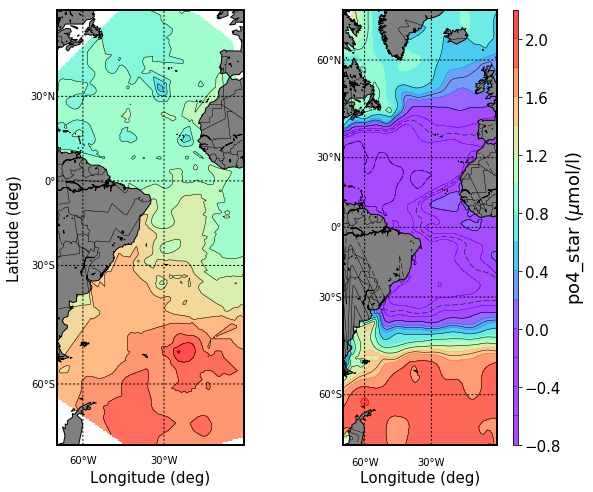

In [34]:
tracers = ['phosphate', 'salinity', 'oxygen']
tracer = 'po4_star'
minlat, maxlat, minlon, maxlon = -70, 70,-70, 0
slice_type = 'plan'

newPlot = rawPlotter([slice_type, slice_type], [tracer])
fig, ax_out = newPlot.make()

dpth = 4000
dataset = dataFetcher()
dataset.get_plan([minlat, maxlat],[minlon, maxlon], tracers, dpth)
dataset = ox_po4_convert(dataset)
fig, ax_out[0] = newPlot.add_plan(fig, ax_out[0], dataset, tracer, dpth, share_limits= [0,2], colorbar = 'n')

dpth = 100
dataset = dataFetcher()
dataset.get_plan([minlat, maxlat],[minlon, maxlon], tracers, dpth)
dataset = ox_po4_convert(dataset)
fig, ax_out[1] = newPlot.add_plan(fig, ax_out[1], dataset, tracer, dpth, share_limits= [0,2])
ax_out[1].yaxis.set_visible(False)


In [35]:
df_Atl = pd.DataFrame(dataset_Atl.cluster_d)

(0, 2.5)

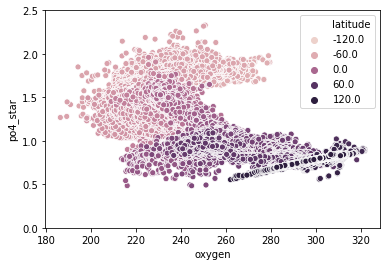

In [36]:
sns.scatterplot(x ='oxygen', y= 'po4_star', data = df_Atl, hue = 'latitude', hue_norm=(-90, 90))
plt.ylim([0,2.5])

(0, 2.5)

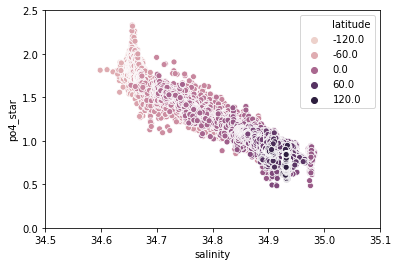

In [37]:
sns.scatterplot(x ='salinity', y= 'po4_star', data = df_Atl, hue = 'latitude', hue_norm=(-90, 90))
plt.xlim([34.5,35.1])
plt.ylim([0, 2.5])

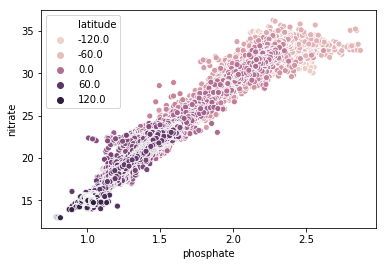

In [38]:
sns.scatterplot(x ='phosphate', y= 'nitrate', data = df_Atl, hue = 'latitude')

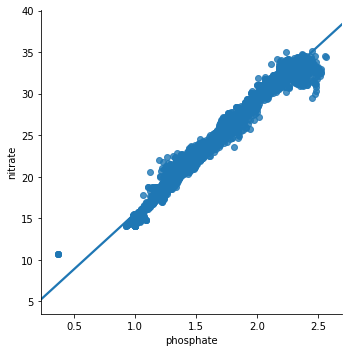

In [88]:
fig = sns.lmplot(x ='phosphate', y= 'nitrate', data = df_Atl)
# sns.lmplot(x ='oxygen', y= 'phosphate', data = df_SAtl, ax = fig)
# plt.ylim([0, 3])

In [40]:
labels = []

for lat in df_Atl.latitude:
    if lat >-20:
        labels.append('NAtl')
    elif lat>-50:
        labels.append('SAtl')
    elif lat>-70:
        labels.append('SO_CDW')
    else:# lat>-70:
        labels.append('SO_shelf')
        
df_Atl['labels']= labels

(34.5, 35.2)

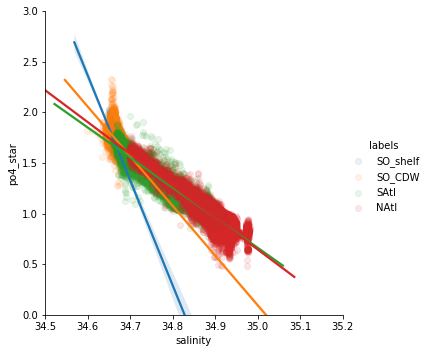

In [43]:
fig = sns.lmplot(x ='salinity', y= 'po4_star', data = df_Atl, hue = 'labels', scatter_kws={'alpha':0.1})
plt.ylim([0, 3])
plt.xlim([34.5, 35.2])

In [3]:
line_lon = -30
min_lat, max_lat = -80, 80

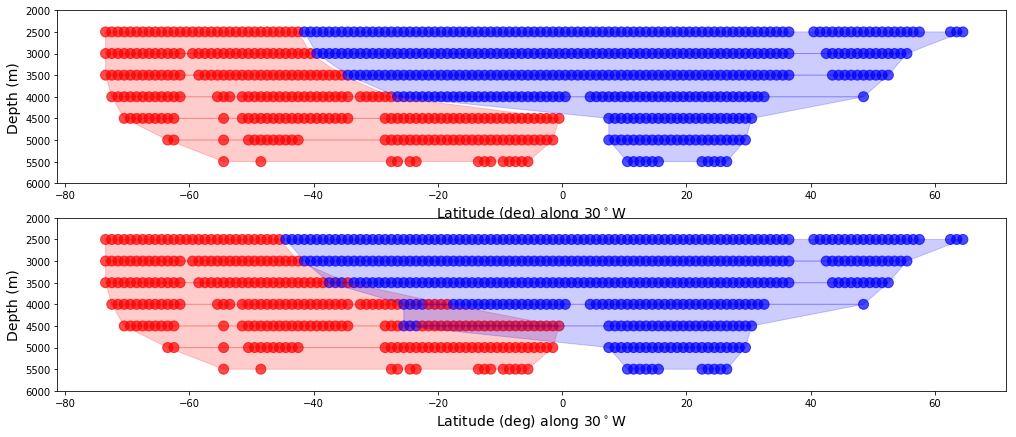

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(17, 7), facecolor='w')

tracers = ['salinity', 'phosphate', 'oxygen']
dataset = dataFetcher()
dataset.get_section('NS_section', line_lon, [min_lat, max_lat], tracers)
dataset = ox_po4_convert(dataset)

depths = [2500, 3000, 3500, 4000, 4500, 5000, 5500]
depth_traj = {}

tracers = ['salinity', 'po4_star']
for im, trcr in enumerate(tracers):
    r = []
    b = []
    d_traj = {}
    for ij, dpth in enumerate(depths):
        Atl = water_column(dataset, 'traj', depth= dpth, tracer=trcr)
        Atl.get_mixing_labels('two_endmember')
        d_traj[dpth] = Atl
        ax[im].scatter(Atl._ax_avgd, [dpth for ik in range(len(Atl._feat_data_avgd))], c = Atl.mixing_labels, alpha = .7, s=100)
        ax[im].set_ylim([6000,2000])

        # create lists of latitudes where there are red points and blue points
        x_int_r = []
        x_int_b = []
        for ip in range(len(Atl._feat_data_avgd)):
            if Atl.mixing_labels[ip] == 'r':
                x_int_r.append(Atl._ax_avgd[ip])
            else:
                x_int_b.append(Atl._ax_avgd[ip])

        # create lists of bounding points for each depth
        r.append([dpth, x_int_r[0], x_int_r[-1]])
        b.append([dpth, x_int_b[0], x_int_b[-1]])

    ### fill code
    r_pairs = [[r[n-1], r[n]] for n in range(1,len(r))]
    b_pairs = [[b[n-1], b[n]] for n in range(1,len(b))]

    pair_sets = {'r':[r_pairs, []], 'b':[b_pairs,[]]}

    for color in pair_sets.keys():
        for pair in pair_sets[color][0]:
            ul = [pair[0][1], pair[0][0]]
            ur = [pair[0][2], pair[0][0]]
            ll = [pair[1][1], pair[1][0]]
            lr = [pair[1][2], pair[1][0]]

            xs = [ik[0] for ik in [ll, ul, ur, lr]]
            ys = [ik[1] for ik in [ll, ul, ur, lr]]

            pair_sets[color][1].append([xs, ys])

        for d in pair_sets[color][1]:
            ax[im].fill(d[0],d[1], c=color, alpha=.2)

    ax[im].set_ylim([6000, 2000])

    ax[im].set_ylabel('Depth (m)', fontsize=axis_sz)
    ax[im].set_xlabel('Latitude (deg) along {}$^\circ$W'.format(-line_lon), fontsize=axis_sz)

    # set tick parameters
    xtickNames = ax[im].get_xticklabels()
    ytickNames = ax[im].get_yticklabels()

    for names in [ytickNames, xtickNames]:
        plt.setp(names, rotation=0, fontsize=tick_sz-4) 
    
    depth_traj[trcr] = d_traj
# name1 = 'two_endmember_Atlantic'
# path = 'raw_demo_plots/connectedness/'
# plt.savefig(path+name1+'.png', dpi=None, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches=None, pad_inches=0.2,
#         frameon=None)



In [61]:
tracers = ['phosphate', 'oxygen', 'nitrate']
tracer_string = ','.join(tracers)
dataset_NA = dataFetcher()
dataset_NA.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 WHERE latitude > 60 and longitude < 15 and longitude >-70 and depth>=3000'.format(tracer_string),['latitude', 'longitude', 'depth']+tracers, tracers, 'longitude', 'latitude')
df_NAtl = pd.DataFrame(dataset_NA.cluster_d)
df_NAtl['label'] = ['NAtl' for ik in range(len(df_NAtl))]

In [62]:
dataset_SA = dataFetcher()
dataset_SA.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 WHERE latitude <-60 and longitude < 15 and longitude >-70 and depth>=4000'.format(tracer_string),['latitude', 'longitude', 'depth']+ tracers, tracers, 'longitude', 'latitude')
df_SAtl = pd.DataFrame(dataset_SA.cluster_d)
df_SAtl['label'] = ['SO' for ik in range(len(df_SAtl))]

In [89]:
df_SNAtl = pd.concat([df_NAtl, df_SAtl])
df_SNAtl['oxygen'] = df_SNAtl['oxygen']*44.661

(0, 3)

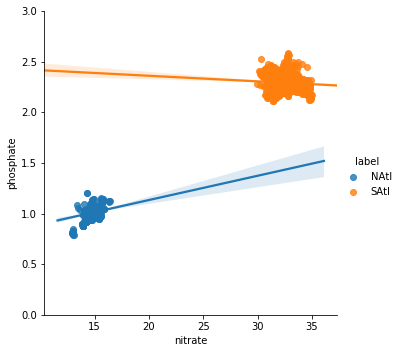

In [69]:
fig = sns.lmplot(x ='nitrate', y= 'phosphate', data = df_SNAtl, hue = 'label')
# sns.lmplot(x ='oxygen', y= 'phosphate', data = df_SAtl, ax = fig)
plt.ylim([0, 3])

(0, 3)

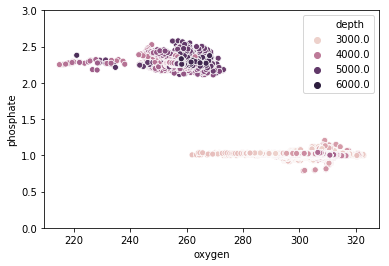

In [91]:
fig = sns.scatterplot(x ='oxygen', y= 'phosphate', data = df_SNAtl, hue = 'depth')
# sns.lmplot(x ='oxygen', y= 'phosphate', data = df_SAtl, ax = fig)
plt.ylim([0, 3])

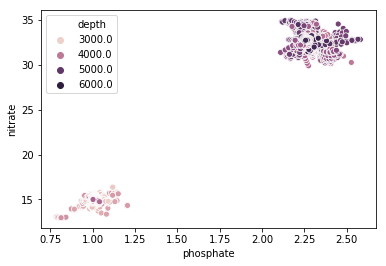

In [68]:
fig = sns.scatterplot(x ='phosphate', y= 'nitrate', data = df_SNAtl, hue = 'depth')
# sns.lmplot(x ='oxygen', y= 'phosphate', data = df_SAtl, ax = fig)


In [10]:
depth_traj['salinity'][2500].mixing_ratios#, depth_traj['salinity'][2500]._x[0]

[array([ 0.96513557,  0.03486443]),
 array([ 0.97007699,  0.02992301]),
 array([ 0.97449917,  0.02550083]),
 array([ 0.97809865,  0.02190135]),
 array([ 0.98041614,  0.01958386]),
 array([ 0.98124408,  0.01875592]),
 array([ 0.98094737,  0.01905263]),
 array([ 0.9800445,  0.0199555]),
 array([ 0.97914014,  0.02085986]),
 array([ 0.9789176,  0.0210824]),
 array([ 0.97982047,  0.02017953]),
 array([ 0.98184574,  0.01815426]),
 array([ 0.98476863,  0.01523137]),
 array([ 0.98871203,  0.01128797]),
 array([ 1.,  0.]),
 array([ 0.97577368,  0.02422632]),
 array([ 0.94917242,  0.05082758]),
 array([ 0.93493783,  0.06506217]),
 array([ 0.94497952,  0.05502048]),
 array([ 0.94093197,  0.05906803]),
 array([ 0.92909279,  0.07090721]),
 array([ 0.91021424,  0.08978576]),
 array([ 0.88495942,  0.11504058]),
 array([ 0.85349317,  0.14650683]),
 array([ 0.81610471,  0.18389529]),
 array([ 0.77406779,  0.22593221]),
 array([ 0.72903605,  0.27096395]),
 array([ 0.68340789,  0.31659211]),
 array([ 0.6

In [8]:
depth_traj['po4_star'][2500].mixing_ratios[0]

array([ 0.92828991,  0.07171009])

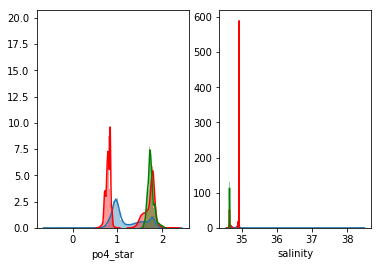

In [176]:
fig = plt.figure()
ax = fig.add_subplot(1,2,1)
sns.distplot(df_Atl.po4_star, norm_hist = True, ax = ax)
sns.distplot(df_Atl[df_Atl['latitude']> 60].po4_star, norm_hist = False, ax = ax, color = 'red')
sns.distplot(df_Atl[(df_Atl['latitude']> -70) &(df_Atl['latitude']<-45) &(df_Atl['depth']>3000)].po4_star, norm_hist =True, ax = ax, color = 'red')
sns.distplot(df_Atl[(df_Atl['latitude']< -70)].po4_star, norm_hist = True, ax = ax, color = 'green')
ax1 = fig.add_subplot(1,2,2)
sns.distplot(df_Atl.salinity, norm_hist = False, ax = ax1)
sns.distplot(df_Atl[df_Atl['latitude']> 60].salinity, norm_hist = False, ax = ax1, color = 'red')
sns.distplot(df_Atl[(df_Atl['latitude']> -70) &(df_Atl['latitude']<-45)].salinity, norm_hist =False, ax = ax1, color = 'red')
sns.distplot(df_Atl[df_Atl['latitude']< -70].salinity, norm_hist = False, ax = ax1, color = 'green')


(34.5, 35.1)

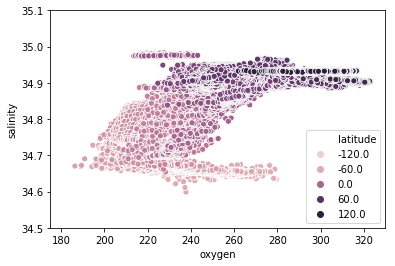

In [178]:
sns.scatterplot(x ='oxygen', y= 'salinity', data = df_Atl, hue = 'latitude', hue_norm=(-90, 90))
plt.ylim([34.5,35.1])
# plt.xlim([0, 2.5])

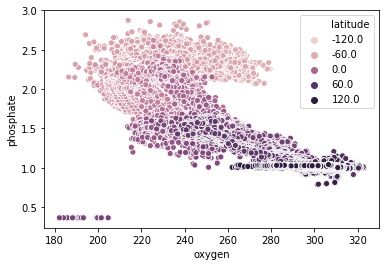

In [180]:
sns.scatterplot(x ='oxygen', y= 'phosphate', data = df_Atl, hue = 'latitude', hue_norm=(-90, 90))